In [61]:
import sys
sys.path.append("../src")
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load scripts
from text_cleaning import clean_text
from clustering import KMeansAuthors, ModHausdorffDocument
from style_point_cloud import style_point_cloud

# Progress bar
from tqdm import tqdm 
tqdm.pandas()

# Data load and preprocessing

In [62]:
df = pd.read_json("../data/gutenberg_sample.json")

# No need to clean the text here, as it is already in good shape. We only need to lowercase it, since
# we assume it.
df.text = df.text.apply(lambda x: x.lower())

# Generate point cloud for each text. Given the size, it's better to impose a limit of tokens
df["point_cloud"] = df.text.progress_apply(lambda text: style_point_cloud(text, window_size=600, window_overlap=300, max_tokens=15_000))

# Remove documents with no points
df = df[df.point_cloud.apply(len) > 0].copy()

100%|██████████| 60/60 [01:19<00:00,  1.33s/it]


In [63]:
# Create an author label for each point
auth_labels = [[author]*n_chunks for author, n_chunks in 
                zip(df.author, df.point_cloud.apply(len))]

# Flatten
auth_labels = [x for y in auth_labels for x in y]

# Model 1

Simple K-Means and identify clusters

In [64]:
data = StandardScaler().fit_transform(np.vstack(df.point_cloud))
X = PCA(n_components=3).fit_transform(data)

cl = KMeansAuthors(n_authors=3)

# Fit data. Pass author labels to assign one author per cluster
cl.fit(X, auth_labels)

In [65]:
# Metrics
author_pred = cl.predict_document(X, df.point_cloud.apply(len).to_numpy())
print(classification_report(y_true = df.author, y_pred = author_pred, zero_division=0))

                              precision    recall  f1-score   support

            Dickens, Charles       0.50      0.50      0.50        20
        Hawthorne, Nathaniel       0.76      0.95      0.84        20
Henty, G. A. (George Alfred)       0.67      0.50      0.57        20

                    accuracy                           0.65        60
                   macro avg       0.64      0.65      0.64        60
                weighted avg       0.64      0.65      0.64        60



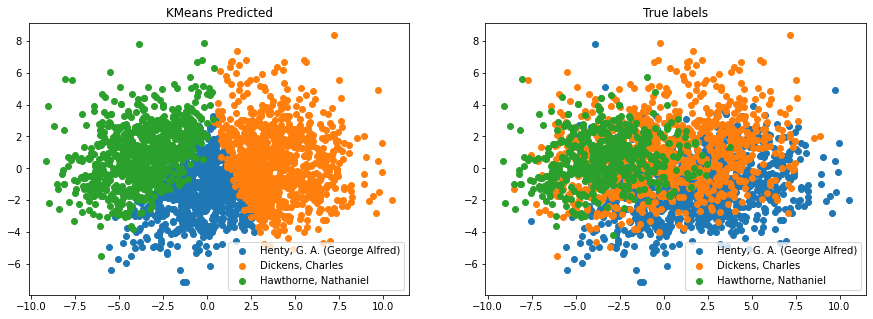

In [66]:
# Since we are doing PCA, let's have a look at some visualizations
predictions = cl.predict(X, author_labels=True)
auth_idx = dict(zip(set(predictions), range(len(set(predictions)))))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
for label in set(predictions): 
    mask_pred = [True if pr == label else False for pr in predictions]
    mask_true = [True if pr == label else False for pr in auth_labels]
    ax1.scatter(X[:, 0][mask_pred], X[:, 1][mask_pred], label=label)
    ax2.scatter(X[:, 0][mask_true], X[:, 1][mask_true], label=label)
    ax1.legend()
    ax2.legend()
    ax1.set_title("KMeans Predicted")
    ax2.set_title("True labels")

# Model 2

Treat each style vector vector as a point and build a point cloud for each document. Then compute distances between them using a modified hausdorff distance and use, e.g., Agglomerative clustering from sklearn---or any other algorithm that admits a pre-computed metric and allow us to input the number of cluster. The latter is of course optional, one could simply run an algorithm that determines the number of clusters, but then it wouldn't be that visual to check the predictions as in this case. 

In [67]:
mhcl = ModHausdorffDocument(n_authors=3)
mhcl.fit(X, doc_lengths=df.point_cloud.apply(len).to_numpy(), author_labels=df.author)

In [68]:
# Metrics
author_pred = mhcl.predict_document()
print(classification_report(y_true = df.author, y_pred = author_pred, zero_division=0))

                              precision    recall  f1-score   support

            Dickens, Charles       0.71      0.75      0.73        20
        Hawthorne, Nathaniel       0.88      0.70      0.78        20
Henty, G. A. (George Alfred)       0.87      1.00      0.93        20

                    accuracy                           0.82        60
                   macro avg       0.82      0.82      0.81        60
                weighted avg       0.82      0.82      0.81        60

